In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan

from CASutils import averaging_utils as avg
from CASutils import qbo_utils as qbo
from CASutils import plotposition_utils as plotpos
from CASutils import readdata_utils as read
from CASutils import colorbar_utils as cbars
from CASutils import plothisto_utils as histo


import importlib
importlib.reload(qbo)
import sys

In [2]:
import importlib
importlib.reload(histo)

<module 'CASutils.plothisto_utils' from '/home/islas/python/CASanalysis/CASutils/plothisto_utils.py'>

In [3]:
plotpath="/project/cas/islas/python_plots/CAM7_vertres_paper/FIGURES/"

In [4]:
basepath="/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/QBOcomposites/monthly/"

In [5]:
mems=['001','002','003']
alldatF = []
for imem in mems:
    dat = xr.open_dataset(basepath+'L83_FHIST_'+imem+'_composite_50hpa.nc')
    alldatF.append(dat)
alldatF = xr.concat(alldatF, dim=mems)
alldatF = alldatF.rename(concat_dim='M')

mems=['001','002','003']
alldatB = []
for imem in mems:
    dat = xr.open_dataset(basepath+'L83_BHIST_'+imem+'_composite_50hpa.nc')
    alldatB.append(dat)
alldatB = xr.concat(alldatB, dim=mems)
alldatB = alldatB.rename(concat_dim='M')

### Dunkerton and Delisi amplitude

In [7]:
mems=['001','002','003']
era5_tem = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/TEMdiags/mon/ERA5.nc").uzm
era5_tem['plev'] = era5_tem.plev/100.

jra55_uzm = xr.open_mfdataset("/project/cas/islas/python_savs/CAM7_vertres_paper/RAW_DATA/JRA55/Uzm/Uzm*.nc")
monstr = xr.DataArray(jra55_uzm.indexes['time'].strftime('%Y%m'), coords=jra55_uzm.time.coords, name='monstr')
time = jra55_uzm.time.groupby(monstr).mean('time')
jra55_uzm = jra55_uzm.groupby(monstr).mean('time')
jra55_uzm = jra55_uzm.rename({'monstr':'time'})
jra55_uzm['time'] = time.values
#jra55_uzm = jra55_uzm.drop_vars('monstr')

merra2_uzm = xr.open_mfdataset("/project/cas/islas/python_savs/CAM7_vertres_paper/RAW_DATA/MERRA2/Uzm/Uzm*.nc")
monstr = xr.DataArray(merra2_uzm.indexes['time'].strftime('%Y%m'), coords=merra2_uzm.time.coords, name='monstr')
time = merra2_uzm.time.groupby(monstr).mean('time')
merra2_uzm = merra2_uzm.groupby(monstr).mean('time')
merra2_uzm = merra2_uzm.rename({'monstr':'time'})
merra2_uzm['time'] = time.values
#merra2_uzm = merra2_uzm.drop_vars('monstr')



mems=['001','002','003']

bl83_tem=[]
for imem in mems: 
    dat = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/TEMdiags/mon/L83_BHIST_"+imem+".nc").uzm
    dat['lat'] = era5_tem.lat 
    bl83_tem.append(dat)
bl83_tem = xr.concat(bl83_tem, dim=mems)
bl83_tem = bl83_tem.rename(concat_dim='M')
bl83_tem = bl83_tem.sel(time=slice("1979-01-01","2023-12-31"))

mems=['001','002','003']

fl83_tem=[]
for imem in mems:
    dat = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/TEMdiags/mon/L83_FHIST_"+imem+".nc").uzm
    dat['lat'] = era5_tem.lat
    fl83_tem.append(dat)
fl83_tem = xr.concat(fl83_tem, dim=mems)
fl83_tem = fl83_tem.rename(concat_dim='M')
fl83_tem = fl83_tem.isel(time=slice(12, fl83_tem.time.size))

# Calculate the tropical average
era5_tem_tr = avg.cosweightlat(era5_tem,-5,5)
jra55_uzm_tr = avg.cosweightlat(jra55_uzm.Uzm, -5, 5)
merra2_uzm_tr = avg.cosweightlat(merra2_uzm.Uzm, -5, 5)
fl83_tem_tr = avg.cosweightlat(fl83_tem,-5,5)
bl83_tem_tr = avg.cosweightlat(bl83_tem,-5,5)

# Deseasonalize
era5_tem_tr_deseas = era5_tem_tr.groupby('time.month') - era5_tem_tr.groupby('time.month').mean('time')
fl83_tem_tr_deseas = fl83_tem_tr.groupby('time.month') - fl83_tem_tr.groupby('time.month').mean('time')
bl83_tem_tr_deseas = bl83_tem_tr.groupby('time.month') - bl83_tem_tr.groupby('time.month').mean('time')
jra55_uzm_tr_deseas = jra55_uzm_tr.groupby('time.month') - jra55_uzm_tr.groupby('time.month').mean('time')
merra2_uzm_tr_deseas = merra2_uzm_tr.groupby('time.month') - merra2_uzm_tr.groupby('time.month').mean('time')

# Calculate the amplitude
dd_era5 = np.sqrt(2)*era5_tem_tr_deseas.std('time')
dd_fl83 = np.sqrt(2)*fl83_tem_tr_deseas.std('time')
dd_bl83 = np.sqrt(2)*bl83_tem_tr_deseas.std('time')
dd_jra55 = np.sqrt(2)*jra55_uzm_tr_deseas.std('time').load()
dd_merra2 = np.sqrt(2)*merra2_uzm_tr_deseas.std('time').load()

DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat


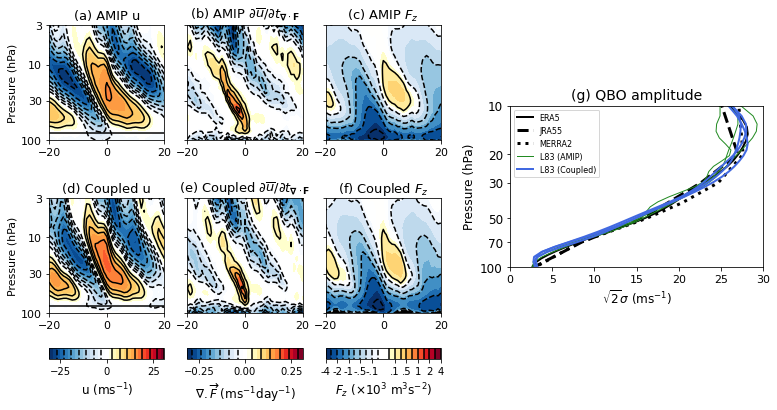

In [9]:
fig = plt.figure(figsize=(16,16))

ax = qbo.plotqbowinds(fig, alldatF.mean('M').uzm, alldatF.time, alldatF.ilev, 2, -30, 30, '(a) AMIP u',0.03,0.13,0.7,0.8, plevvar='ilev', 
                      contourlines=True, contourlinescale=2, fsize=11)
ax.plot([-20,20],[-np.log10(80),-np.log10(80)], color='black')

ax = qbo.plotqbowinds(fig, 86400.*alldatF.mean('M').utendepfd, alldatF.time, alldatF.ilev,0.025,-0.3,0.3,
                      r'(b) AMIP $\partial\overline{u}/\partial t_{\mathbf{\nabla}\cdot\mathbf{F}}$',
                      0.15,0.25,0.7,0.8, plevvar='ilev',
                      contourlines=True, contourlinescale=2, ylabel=False, fsize=11)

clevs=[-4000,-3000,-2000,-1500,-1000,-750,-500,-250,-100,-50,0,
       50,100,250,500,750,1000,1500,2000,3000,4000]
ax = qbo.plotqbowinds(fig, alldatF.mean('M').epfz, alldatF.time, alldatF.ilev, 0.1, -1, 1, 
                      '(c) AMIP $F_{z}$',0.27,0.37,0.7,0.8, plevvar='ilev',
                      speclevs=clevs, contourlines=True, contourlinescale=2, ylabel=False, fsize=11)


ax = qbo.plotqbowinds(fig, alldatB.mean('M').uzm, alldatB.time, alldatB.ilev, 2, -30, 30, '(d) Coupled u',0.03,0.13,0.55,0.65,plevvar='ilev',
                      contourlines=True, contourlinescale=2, fsize=11)
ax.plot([-20,20],[-np.log10(80),-np.log10(80)], color='black')

ax = qbo.plotqbowinds(fig, 86400.*alldatB.mean('M').utendepfd, alldatB.time, alldatB.ilev, 0.025,-0.3,0.3,
                      r'(e) Coupled $\partial\overline{u}/\partial t_{\mathbf{\nabla}\cdot\mathbf{F}}$',
                      0.15,0.25,0.55,0.65,plevvar='ilev',
                      contourlines=True, contourlinescale=2, ylabel=False, fsize=11)

ax = qbo.plotqbowinds(fig, alldatB.mean('M').epfz, alldatB.time, alldatB.ilev, 0.1,-1,1,
                      '(f) Coupled $F_{z}$',0.27,0.37,0.55,0.65, plevvar='ilev',
                      speclevs=clevs, contourlines=True, contourlinescale=2, ylabel=False, fsize=11)




ax = cbars.plotcolorbar(fig, 2, -30, 30, 'u (ms$^{-1}$)',0.03,0.13,0.51,0.52,contourlines=True, contourlinescale=2, fsize=10)


ax = cbars.plotcolorbar(fig, 0.025,-0.3,0.3,r'$\nabla.\overrightarrow{F}$ (ms$^{-1}$day$^{-1}$)',0.15,0.25,0.51,0.52, contourlines=True, 
                        contourlinescale=2, fsize=10)
#ax = cbars.plotcolorbar_sayc(fig, clevs, '$\overrightarrow{F}_{p}$ ( $\times$10$^{4}$ m$^{2}$s$^{-2}$)',0.27,0.37,0.51,0.52, contourlines=True,
#                             ticks=['-4','-2','-1','-0.5','-0.1','0.1','0.5','1','2','4'])
ax = cbars.plotcolorbar_sayc(fig, clevs, '$F_{z}$ ($\\times$10$^{3}$ m$^{3}$s$^{-2}$)',0.27,0.37,0.51,0.52, contourlines=True,
                            ticks=[-4000,-2000,-1000,-500,-100,100,500,1000,2000,4000], 
                            ticklabels=['-4','-2','-1','-.5','-.1','.1','.5','1','2','4'], fsize=10)




ax =fig.add_axes([0.43,0.59,0.22,0.14])
ax.plot(dd_era5, -1*np.log10(dd_era5.plev), linewidth=2, color='black', label='ERA5')
ax.set_ylim(-np.log10(100),-np.log10(10))
ax.set_xlim(0,30)
ax.set_yticks([-np.log10(100), -np.log10(70), -np.log10(50), -np.log10(30), -np.log10(20), -np.log10(10)])
ax.set_yticklabels(['100','70','50','30','20','10'], fontsize=12)
ax.set_ylabel('Pressure (hPa)', fontsize=12)
ax.set_xlabel('$\sqrt{2}\sigma$ (ms$^{-1}$)', fontsize=12)
ax.set_title('(g) QBO amplitude', fontsize=14)

ax.plot(dd_jra55, -np.log10(dd_jra55.pre), color='black', linewidth=3, linestyle='dashed', label='JRA55')
ax.plot(dd_merra2, -np.log10(dd_merra2.lev), color='black', linewidth=3, linestyle='dotted', label='MERRA2')

for imem in np.arange(0,3,1):
    ax.plot(dd_fl83.isel(M=imem), -1.*np.log10(dd_fl83.ilev), linewidth=1, color='forestgreen', label='L83 (AMIP)' if imem == 0 else '')
    
for imem in np.arange(0,3,1):
    ax.plot(dd_bl83.isel(M=imem), -1.*np.log10(dd_bl83.ilev), linewidth=2, color='royalblue', label='L83 (Coupled)' if imem == 0 else '')

ax.legend(fontsize=8)

fig.savefig(plotpath+'fig15.pdf', bbox_inches='tight', facecolor='white')